<a href="https://colab.research.google.com/github/Stavroskiig/MLP-kNN-NC-CIFAR-100/blob/main/NN_1st_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Νευρωνικά Δίκτυα - Βαθιά Μάθηση**

1η Υποχρεωτική Εργασία


---
* **Στόχος**:
Ζητούμενο της εργασίας είναι να γραφεί πρόγραμμα σε οποιαδήποτε γλώσσα προγραμματισμού το οποίο να υλοποιεί ένα νευρωνικό δίκτυο πολυστρωματικού perceptron (το δίκτυο μπορεί να είναι πλήρως συνδεδεμένο ή συνελικτικό ή συνδυασμός) που θα εκπαιδεύεται με τον αλγόριθμο back-propagation. Το NN αυτό θα
εκπαιδευτεί για να επιλύει οποιοδήποτε πρόβλημα κατηγοριοποίησης πολλών κλάσεων εκτός MNIST.

* **Γλώσσα**:
Επιλέγω να εργαστώ σε Python χρησιμοποιώντας την βιβλιοθήκη `PyTorch` για την ανάπτυξη των νευρωνικών μοντέλων, η οποία είναι αρκετά δημοφιλής στην ερευνητική και εκπαιδευτική κοινότητα. Αντίστοιχα, για τα πρώτα μοντέλα της ενδιάμεσης εργασίας επιλέγω την `sklearn`.

* **Βάση Δεδομένων**:
Για την εκπαίδευση και την κατηγοριοποίηση αποφάσισα να χρησιμοποιήσω την βάση δεδομένων CIFAR-100 που υπάρχει στην παρακάτω διεύθυνση:
https://www.cs.toronto.edu/~kriz/cifar.html


---



# Φόρτωση του dataset

1.   **Πρώτος τρόπος**

Αρχικά θα φορτώσω το σύνολο δεδομένων στο colab. Κατεβάζοντας τον αντίστοιχο φάκελο για την Python από το παραπάνω link, βρίσκω μέσα το αρχείο train, όπως και το test. Κάθε ένα από αυτά τα αρχεία είναι ένα Python "pickled" αντικείμενο που σχηματίστηκε με το cPickle. Με την παρακάτω συνάρτηση μπορώ να ανοίξω ένα τέτοιο αρχείο και να επιστρέψω ένα dictionary:

In [ ]:
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

Αποθήκευσα το σύνολο δεδομένων στο Google Drive, οπότε με τον παρακάτω τρόπο μπορώ να το φορτώσω και εδώ, δίνοντας άδεια στο Colab να επικοινωνεί με το Drive του λογαρισμού. Αυτό χρειάζεται να γίνει μόνο μία φορά.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Κάνω χρήση της προηγούμενης συνάρτησης για να πάρω το λεξικό.

In [ ]:
cifar100 = unpickle('/content/drive/MyDrive/cifar-100-python/train')

2.   **Δεύτερος τρόπος**

Εισάγω το dataset απευθείας από το PyTorch. Στη συνέχεια το χωρίζω σε train και test σετ ορίζοντας πρώτα τον transformer που μετατρέπει τις εικόνες σε tensors. Τέλος, ορίζω και τους data loaders, οι οποίοι φροντίζουν για τη φόρτωση, το shuffle και την ομαδοποίηση των δεδομένων, διευκολύνοντας την εκπαίδευση των μοντέλων.

In [ ]:
import torch
from torchvision.datasets import CIFAR100
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR100(root='./data', train=False, transform=transform, download=True)

batch_size = 64
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

3.   **Τρίτος τρόπος**

Αυτός ο τρόπος είναι επίσης απλός, αλλά αφορά την χρήση του keras και το δείχνω χάριν πληρότητας. Ουσιαστικά παίρνω το dataset από την keras. Βεβαίως απαιτείται πρώτα να εισάγω την TensorFLow.



In [ ]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

169001437/169001437 [==============================] - 6s 0us/step


Αυτό μου επιστρέφει:
* **x_train**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (50000, 32, 32, 3), που περιέχουν τα δεδομένα εκπαίδευσης (train). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_train**: uint8 NumPy πίνακας ετικετών (labels) (ακέραιοι του εύρους 0-99) με shape (50000, 1) για τα δεδομένα εκπαίδευσης (train).

* **x_test**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (10000, 32, 32, 3), που περιέχουν τα δεδομένα δοκιμής (test). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_tes**t: uint8 NumPy πίνακας ετικετών (ακέραιοι στο εύρος 0-99) με shapes (10000, 1) για τα δεδομένα δοκιμής (test).

# Το CIFAR-100 Dataset

Κάπου έδω θα μελετήσω λίγο το dataset, την δομή του και το περιεχόμενό του. Για αυτό το σκοπό θα χρησιμοποιήσω την πρώτη μέθοδο φόρτωσής του. Γενικά, έχει 100 κλάσεις που περιέχει 600 εικόνες η καθεμιά. Υπάρχουν 500 εικόνες εκπαίδευσης και 100 εικόνες testing ανά κλάση. Οι 100 classes στο CIFAR-100 είναι χωρισμένες σε 20 υπερκλάσεις (superclasses). Κάθε εικόνα έχει μια "fine" ετικέτα (η κλάση στην οποία ανήκει) και μια "coarse" ετικέτα (η superclass στην οποία ανήκει).

In [ ]:
print(type(cifar100))
print(len(cifar100))

<class 'dict'>
5


Βλέπω πως το σύνολο cifar100 είναι ένα λεξικό με 5 κλειδιά. Τώρα θα τυπώσω τα κλειδιά αυτά.

In [ ]:
print("Keys:", list(cifar100.keys()))

Keys: [b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']


Θα τυπώσω και τις τιμές.

In [ ]:
%%capture
# κρύβω για τώρα το output
for key, value in cifar100.items():
    print(key, ":", value)

Ας δούμε τώρα από τι αποτελείται το λεξικό.
* **b'filenames'**: Περιέχει τα ονόματα των εικόνων.
* **b'batch_label'**: Περιέχει την ονομασία του τωρινού batch εκπαίδευσης.
* **b'fine_labels'**: Περιέχει την κλάση που ανήκει κάθε εικόνα.
* **b'coarse_labels'**: Περιέχει την superclass που ανήκει κάθε εικόνα.
* **b'data'**: Περιέχει τις εικόνες υπό την μορφή συνόλου pixels.

Το 'b' σημαίνει ότι οι συμβολοσειρές είναι σε μορφή byte και όχι σε μορφή χαρακτήρων Unicode.

In [ ]:
cifar100[b'data']

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

In [ ]:
cifar100[b'data'].shape

(50000, 3072)

Επιβεβαιώνω πως έχω 50.000 εικόνες εκπαίδευσης και 3072 τιμές pixel που προκύπτουν από τα τρία κανάλια RGB με 3072/3=1024 το κάθενα. Κάθε κανάλι είναι ένας πίνακας με 32x32=1024 τιμές. Οι πρώτες 1024 καταχωρήσεις περιέχουν τις τιμές του κόκκινου (R) καναλιού, οι επόμενες 1024 το πράσινο (G) και οι τελευταίες 1024 το μπλε (B). Η εικόνα αποθηκεύεται με τέτοια σειρά, έτσι ώστε οι πρώτες 32 καταχωρήσεις του πίνακα να είναι οι τιμές του κόκκινου καναλιού της πρώτης σειράς της εικόνας.

In [ ]:
cifar100[b'data'][0]

array([255, 255, 255, ...,  10,  59,  79], dtype=uint8)

In [ ]:
cifar100[b'data'][0].shape

(3072,)

Αυτές οι τίμες pixels είναι ουσιαστικά η πρώτη εικόνα του dataset. Ας την προβάλω κιόλας. Για αυτό με την εντολή `image = image.reshape(3, 32, 32)` αναδιαμορφώνω τα δεδομένα της εικόνας ως τρία κανάλια (R, G, B) και μέγεθος 32x32 pixel. Στην συνέχεια προβάλω την εικόνα, αφού αλλάξω την σειρά όπως θέλει η `matplotlib`.

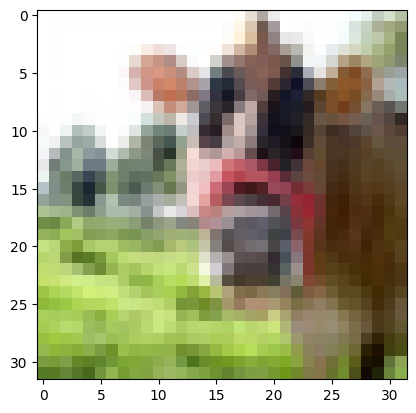

In [ ]:
image = cifar100[b'data'][0]
image = image.reshape(3,32,32).transpose(1,2,0)

from matplotlib import pyplot as plt
plt.imshow(image)

Τώρα θα εφαρμόσω τον ίδιο μετασχηματισμό για όλο το σύνολο. Με την εντολη `data = data.reshape(len(data), 3, 32, 32)` αναδιαμορφώνω τα δεδομένα της εικόνας ως τρία κανάλια (R, G, B) και μέγεθος 32x32 pixel, ακριβώς όπως πριν. Πλέον ο πίνακας `data` είναι της μορφής `[num_images, num_channels, height, width] `. Εγώ όμως θέλω την μορφή `[num_images, height, width, num_channels]` ώστε να το δεχτεί σωστά η `matplotlib`. Οπότε με την εντολή `.transpose(0,2,3,1)` αλλάζω αυτή την σειρά.


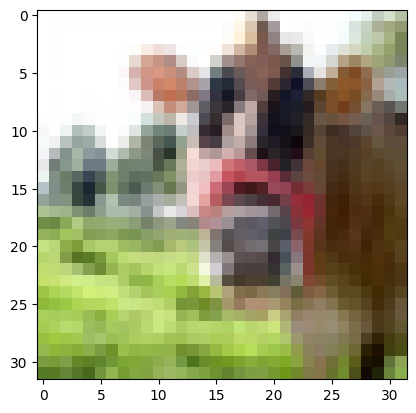

In [ ]:
data = cifar100[b'data']
data = data.reshape(len(data),3,32,32).transpose(0,2,3,1)
plt.imshow(data[0])

Έλεγξα ότι η αναδιαμόρφωση έγινε σωστά. Τώρα θα προβάλω κάποια πλέγματα εικόνων.

<function matplotlib.pyplot.show(close=None, block=None)>

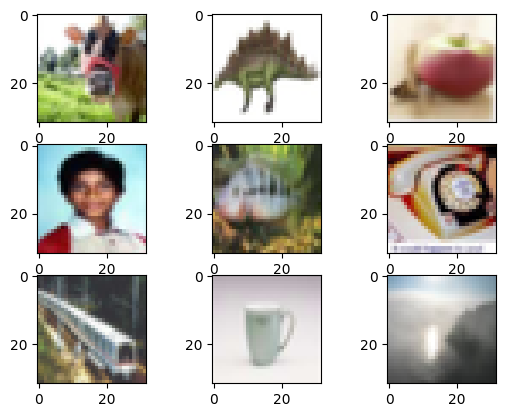

In [ ]:
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(data[i])
plt.show

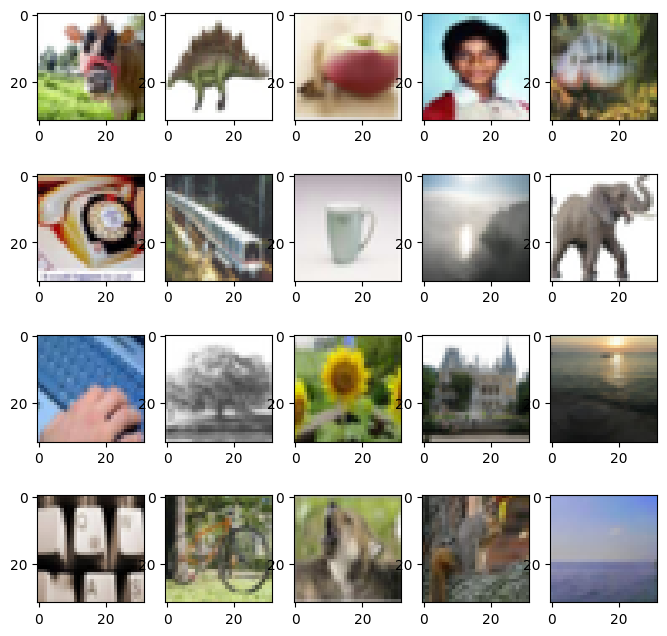

In [ ]:
columns = 5
rows = 4
fig = plt.figure(figsize=(8,8))
for i in range(1, columns*rows+1):
  fig.add_subplot(rows,columns,i)
  plt.imshow(data[i-1])
plt.show()

# Προεπεξεργασία του CIFAR-100

Αρχικά, θα το φορτώσω με την τρίτη μέθοδο αυτή την φορά, ώστε στη συνέχεια να προχωρήσω με τα υπό εξέταση μοντέλα, δηλαδή τα k-NN και Nearest Centroid. Αυτό το κάνω για απλούστευση της διαδικασίας.

In [16]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

Θα δω τα shapes των συνόλων. Τα `x` σύνολα περιλαμβάνουν τις εικόνες, ενώ τα `y` τις ετικέτες.

In [17]:
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

x_train: (50000, 32, 32, 3) y_train: (50000, 1)
x_test: (10000, 32, 32, 3) y_test: (10000, 1)


* Τα `x_train` και `x_test` έχουν το shape: (πλήθος εικόνων, ύψος, πλάτος, πλήθος καναλιών).
* Τα `y_train` και `y_test` είναι 2D πίνακες με shape: (πλήθος εικόνων, 1)

Μετατρέπω τα σύνολα σε `float32`.

In [18]:
import numpy as np

x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)

Θα κάνω flatten τις εικόνες από 3D σε διανύσματα 1D.

In [19]:
number_features = 3072

x_train = x_train.reshape([-1, number_features])
x_test = x_test.reshape([-1, number_features])

print("x_train:", x_train.shape, "x_test:", x_test.shape)

x_train: (50000, 3072) x_test: (10000, 3072)


Θα τις κανονικοποιήσω στο εύρος [0,1].

In [20]:
x_train = x_train/255.0
x_test = x_test/255.0

Κρατώ τον αριθμό των κλάσεων και των υπερκλάσεων για το μέλλον.

In [21]:
number_classes = 100
number_superclasses = 20

Θα εφαρμόσω one-hot encoding, η οποία είναι μια μέθοδος που δέχεται ως είσοδο έναν πίνακα ακεραίων ή strings και συγκεκριμένα τα labels. Τα κωδικοποιεί χρησιμοποιώντας ένα σχήμα κωδικοποίησης one-hot (γνωστό και ως «one-of-K» ή «dummy»). Αυτό δημιουργεί μια binary στήλη για κάθε κατηγορία και επιστρέφει έναν αραιό πίνακα ή έναν πυκνό πίνακα (ανάλογα με την παράμετρο sparse_output). Αναμένω η έξοδος να είναι της μορφής που παρουσιάζεται στην εικόνα. Η συγκεκριμένη τεχνική πάντως δεν επηρεάζει την απόδοση αυτών των classifiers, παρά μόνο των νευρωνικών δικτύων που θα υλοποιηθούν αργότερα.
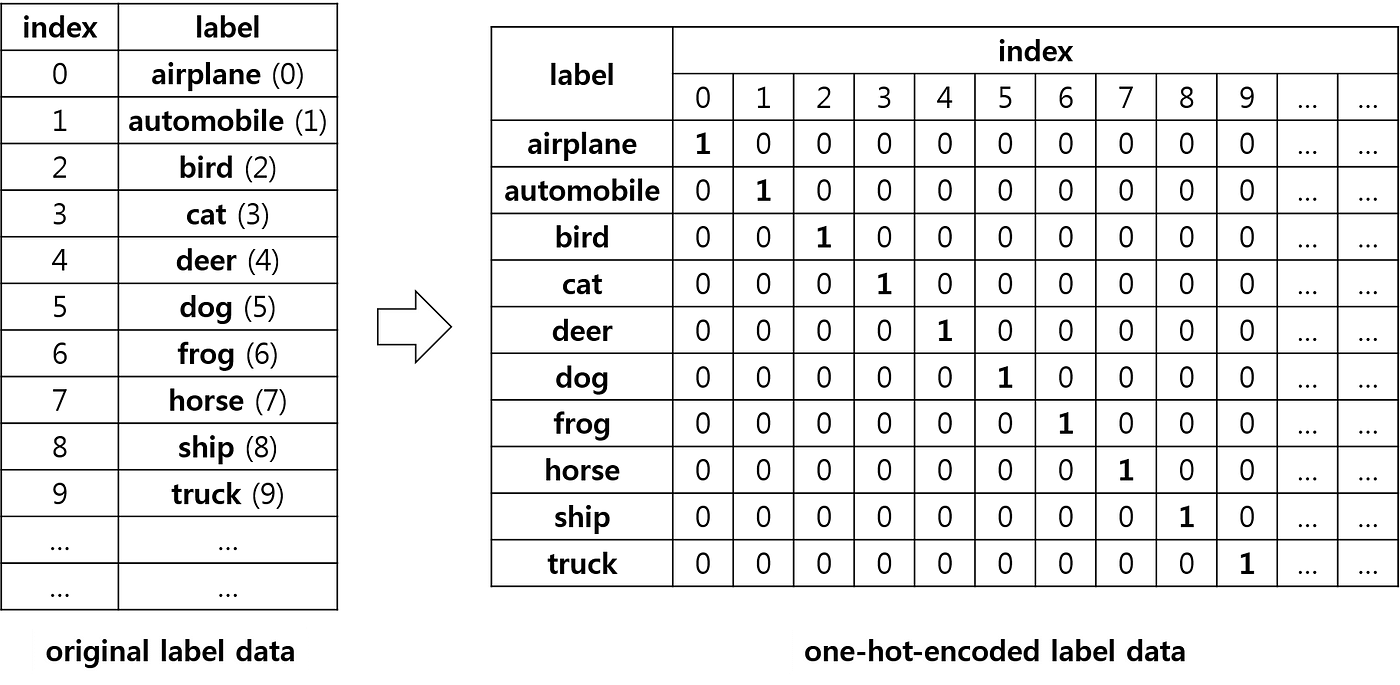

In [22]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.fit_transform(y_test)

# k-NN Models

Εισάγω από την κατάλληλη βιβλιοθήκη (`sklearn`) τον κατηγοριοποιητή πλησιέστερου γείτονα.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Εισάγω και την βιβλιοθήκη `time` για την χρονομέτρηση της εκπαίδευσης και της αξιολόγησης.

In [ ]:
import time

Ορίζω τις συναρτήσεις train και test αντίστοιχα.

In [ ]:
def train_knn_classifier(x_train, y_train, n_neighbors, metric):
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

    start_time = time.time()
    knn_classifier.fit(x_train, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f}s\n")

    return knn_classifier

In [ ]:
def test_knn_classifier(knn_classifier, x_test, y_test):
    start_time = time.time()
    score = knn_classifier.score(x_test, y_test)
    end_time = time.time()

    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f}s\n")

    return score

* **1-NN Model**

Αρχικά φτιάχνω τον κατηγοριοποιητή ενός κοντινού γείτονα με `p=2`, δηλαδή επιλέγοντας την ευκλείδια απόσταση ως υπερπαράμετρο της μετρικής Minkowski.

Η απόσταση Minkowski είναι μια γενικευμένη απόσταση σε έναν κανονικοποιημένο διανυσματικό χώρο. Ακολουθεί ο τύπος που την ορίζει. Για c ίσο με 1, ο τύπος δίνει την απόσταση Manhattan. Όταν το c είναι ίσο με 2, δίνει την Euclidean απόσταση.

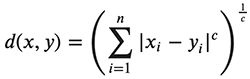

Η ευκλείδια απόσταση σύμφωνα με το σχήμα υπολογίζεται ως εξής. Αφαιρώ το X1 από το X2, τετραγωνίζω το αποτελέσμα, κάνω το ίδιο για τα Y1 και Y2, προσθέτω τα δύο τετράγωνα και στο τέλος τα "βάζω" κάτω από τετραγωνική ρίζα.

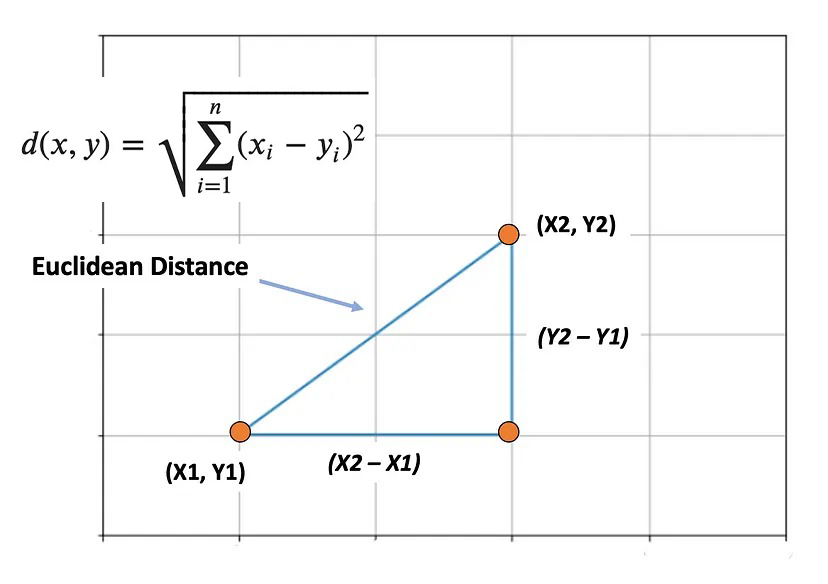

Συνεχίζω τώρα με το κατηγοριοποιητή.

In [ ]:
knn_classifier_1 = train_knn_classifier(x_train, y_train, n_neighbors=1, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_1, x_test, y_test)

print(f"For the 1-NN classifier with Euclidean distance metric, the accuracy is: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Training time: 0.1235s

Testing time: 137.1590s

For the 1-NN classifier with Euclidean distance metric, the accuracy is: 0.1755


Οπότε πετυχαίνω **0.1755** ακρίβεια, δηλαδή αρκετά χαμηλή. Τώρα θα δοκιμάσω αν αλλάζει κάτι ελέγχοντας τρεις γείτονες.

* **3-NN Model**

In [ ]:
knn_classifier_3 = train_knn_classifier(x_train, y_train, n_neighbors=3, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_3, x_test, y_test)

print(f"For the 3-NN classifier with Euclidean distance metric, the accuracy is: {accuracy:.4f}")

Training time: 0.0756s



/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Testing time: 146.8558s

For the 3-NN classifier with Euclidean distance metric, the accuracy is: 0.1479


Παρατηρώ πως ναι μεν χρειάζεται παραπάνω χρόνο όπως αναμενόταν, αλλά η ακρίβεια έπεσε στο **0.1479**.

# Nearest Centroid Models

Ο Nearest Centroid Classifier (NCC) είναι ένα μοντέλο ταξινόμησης που αποδίδει σε παρατηρήσεις την ετικέτα της κατηγορίας δειγμάτων εκπαίδευσης των οποίων ο μέσος όρος (κεντροειδές/centroid) είναι πλησιέστερος στην παρατήρηση.

Μιλώντας με μαθηματικούς όρους, δεδομένου του συνόλου $\left \{ \left ( \vec{x_{1}}, \vec{y_{1}} \right ),..., \left ( \vec{x_{n}}, \vec{y_{n}} \right ) \right \}$, με τα $y_{i}\in \mathbf{Y}$ να είναι οι ετικέτες των κλάσεων, υπολογίζει τους centroids ανά κλάση ως $\vec{\mu _{l}}=\frac{1}{\left | C_{l} \right |}\sum _{i\in C_{l}}\vec{x_{i}}$, όπου $C_{l}$ είναι το σύνολο των δειγμάτων που ανήκουν στην κλάση $l\in \mathbf{Y}$.

Στην φάση της πρόβλεψης η κλάση που αποδίδεται σε μία παρατήρηση $\vec{x}$ είναι το αποτελέσμα του $\hat{y}=\arg \min _{l\in \mathbf{Y}}\left \| \vec{\mu _{l}} - \vec{x} \right \|$.

Όμοια με πριν, θα ορίσω πρώτα τις συναρτήσεις εκπαίδευσης και δοκιμής για καλύτερη ευελιξία.

In [ ]:
from sklearn.neighbors import NearestCentroid
import time

In [ ]:
def train_nearest_centroid_classifier(x_train, y_train, metric):
    ncc_classifier = NearestCentroid(metric=metric)

    start_time = time.time()
    ncc_classifier.fit(x_train, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f}s\n")

    return ncc_classifier

In [ ]:
def test_nearest_centroid_classifier(ncc_classifier, x_test, y_test):
    start_time = time.time()
    score = ncc_classifier.score(x_test, y_test)
    end_time = time.time()

    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f}s\n")

    return score

* **Ευκλείδια απόσταση**

Τώρα θα τεστάρω τον κατηγοριοποιητή `NearestCentroid`, αρχικά με μετρική την Ευκλείδια απόσταση.

In [ ]:
ncc_classifier_euclidean = train_nearest_centroid_classifier(x_train, y_train, metric='euclidean')

accuracy = test_nearest_centroid_classifier(ncc_classifier_euclidean, x_test, y_test)

print(f"For the Nearest Centroid classifier with Euclidean distance metric, the accuracy is: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: 0.3139s

Testing time: 0.5978s

For the Nearest Centroid classifier with Euclidean distance metric, the accuracy is: 0.1004


Παρατηρώ πως είναι πολύ γρήγορο, αλλά με χειρότερη ακρίβεια (**0.1004**) σε σχέση με τα k-NN. Θα δοκιμάσω να αλλάξω την μετρική στην απόσταση Μανχάταν.

* **Απόσταση Μανχάταν**

Η απόσταση Manhattan διαφέρει από την Ευκλείδια όταν υπολογίζουμε την διαφορά  μεταξύ δύο σημείων χρησιμοποιώντας την απόλυτη τιμή της διαφοράς. Με άλλα λόγια, η απόσταση μεταξύ του σημείου x και του y ισούται με το άθροισμα των απόλυτων διαφορών του Y με το X σε κάθε διάσταση.

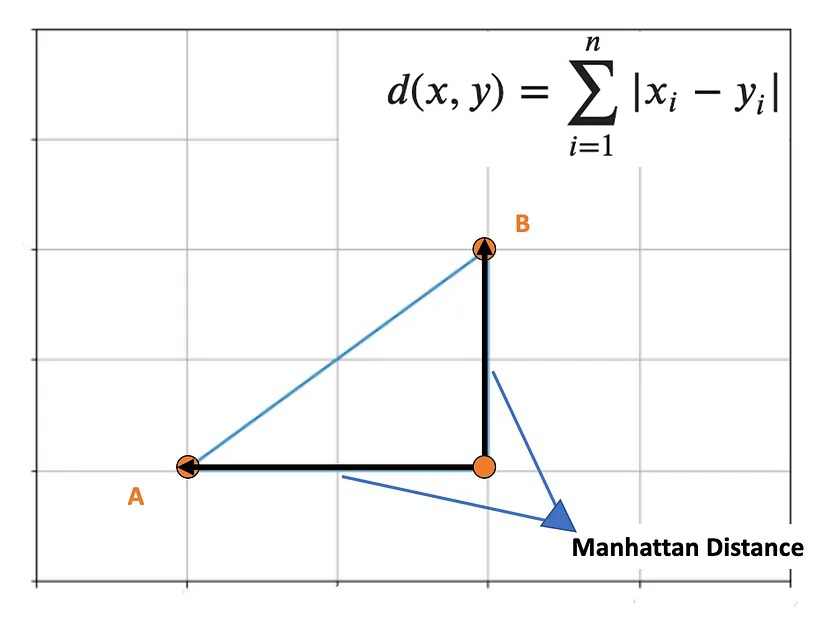

In [ ]:
ncc_classifier_manhattan = train_nearest_centroid_classifier(x_train, y_train, metric='manhattan')

accuracy = test_nearest_centroid_classifier(ncc_classifier_manhattan, x_test, y_test)

print(f"For the Nearest Centroid classifier with Manhattan distance metric, the accuracy is: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: 4.5756s

Testing time: 3.7146s

For the Nearest Centroid classifier with Manhattan distance metric, the accuracy is: 0.1045


Τώρα είναι πιο αργό και ελάχιστα πιο ακριβές (**0.1045**) από πριν.

Γενικά, βλέπω πως έχω πετύχει αρκετά χαμηλή ακριβεία. Για αυτό το λόγο θα χρησιμοποιήσω την μεθόδους του feature extraction για να την βελτιώσω.

# Feature extraction

Η εξαγωγή χαρακτηριστικών (feature extraction) είναι η διαδικασία μετατροπής και μείωσης των πληροφοριών που περιέχονται σε raw data, όπως εικόνες ή κείμενο, σε μια πιο περιεκτική μορφή. Σε δεδομένα εικόνας, η εξαγωγή χαρακτηριστικών συχνά γίνεται με την μέθοδο PCA (Principal Component Analysis) για τη μείωση της διάστασης, καθιστώντας το κατάλληλο για χρήση σε μοντέλα μηχανικής μάθησης. Βοηθά στη βελτίωση της αποδοτικότητας του μοντέλου και μπορεί να αποκαλύψει μοτίβα ή νέα χαρακτηριστικά στα δεδομένα.

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.90)

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

Θέλω το PCA να διατηρήσει τα κύρια στοιχεία που καλύπτουν τουλάχιστον το 90% της διακύμανσης στα δεδομένα, εξού και `n_components=0.90`. Μετά εφαρμόζω το PCA στα δεδομένα και τα μετασχηματίζω.

Ας δούμε την μεταβολή του αριθμού των features.

In [9]:
print("Number of features before PCA: ", x_train.shape[1])
print("Number of features after PCA: ", x_train_pca.shape[1])

Number of features before PCA:  3072
Number of features after PCA:  87


Από 3072 μειώθηκαν στα 87.

* **1-NN Model**

In [10]:
knn_classifier_1 = train_knn_classifier(x_train_pca, y_train, n_neighbors=1, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_1, x_test_pca, y_test)

print(f"For the 1-NN classifier with Euclidean distance metric, the accuracy is: {accuracy:.4f}")

NameError: ignored

Πριν το PCA είχα **0.1755** ακρίβεια, ενώ τώρα **0.1943**. Θα δω τι συμβαίνει και στο 3-NN μοντέλο, αλλά και στα nearest centroid.

* **3-NN Model**

In [ ]:
knn_classifier_3 = train_knn_classifier(x_train_pca, y_train, n_neighbors=3, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_3, x_test_pca, y_test)

print(f"For the 3-NN classifier with Euclidean distance metric, the accuracy is: {accuracy:.4f}")

Εδώ τώρα έχω **0.1645**, ενώ πριν **0.1479**.

* **Ευκλείδια απόσταση**

In [ ]:
ncc_classifier_euclidean = train_nearest_centroid_classifier(x_train_pca, y_train, metric='euclidean')

accuracy = test_nearest_centroid_classifier(ncc_classifier_euclidean, x_test_pca, y_test)

print(f"For the Nearest Centroid classifier with Euclidean distance metric, the accuracy is: {accuracy:.4f}")

Εδώ η ακρίβεια έμεινε περίπου ίδια, από **0.1004** πήγε **0.1001**.

* **Απόσταση Μανχάταν**

In [ ]:
ncc_classifier_euclidean = train_nearest_centroid_classifier(x_train_pca, y_train, metric='manhattan')

accuracy = test_nearest_centroid_classifier(ncc_classifier_euclidean, x_test_pca, y_test)

print(f"For the Nearest Centroid classifier with Manhattan distance metric, the accuracy is: {accuracy:.4f}")

Σε αυτό το μοντέλο η ακρίβεια πήγε **0.1113** από το **0.1045**.

# Σύγκριση Μοντέλων

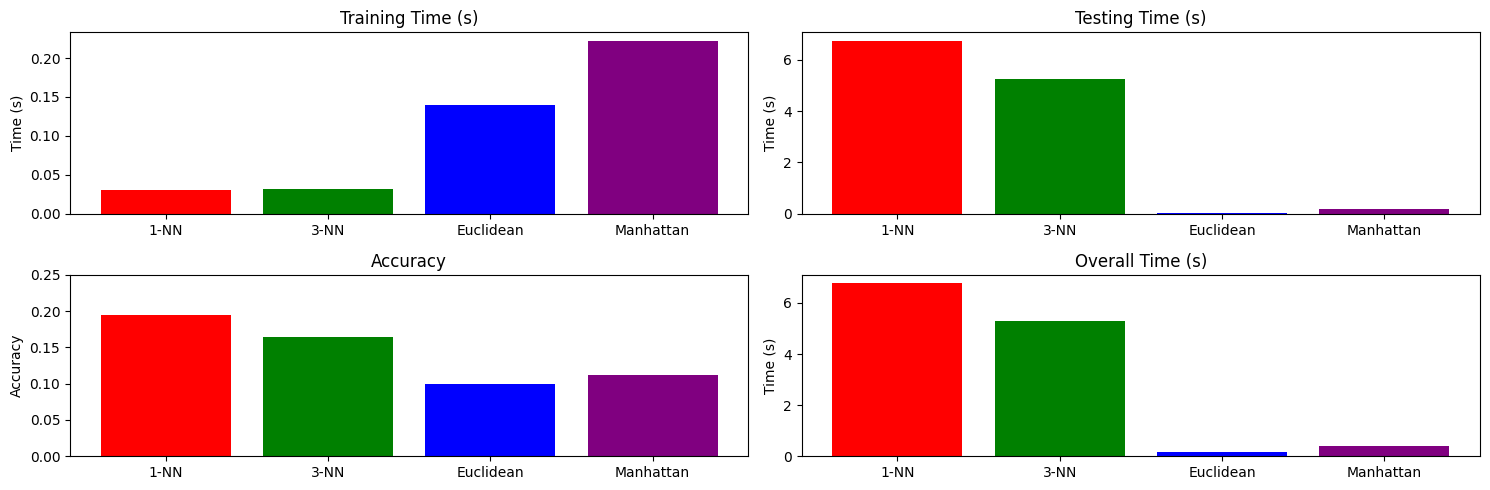

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ["1-NN", "3-NN", "Euclidean", "Manhattan"]
accuracies = np.array([0.1943, 0.1645, 0.1001, 0.1113])
training_time = np.array([0.0311, 0.0317, 0.1401, 0.2219])
testing_time = np.array([6.7278, 5.2631, 0.0237, 0.1885])
overall_time = np.array(np.add(training_time, testing_time))

model_colors = {
    "1-NN": "red",
    "3-NN": "green",
    "Euclidean": "blue",
    "Manhattan": "purple"
}

fig, axs = plt.subplots(2, 2, figsize=(15, 5))

# Subplot 1: Accuracy
accuracy_colors = [model_colors[model] for model in models]
axs[1][0].bar(models, accuracies, color=accuracy_colors)
axs[1][0].set_ylim(0, 0.25)
axs[1][0].set_title("Accuracy")
axs[1][0].set_ylabel("Accuracy")

# Subplot 2: Training Time
training_time_colors = [model_colors[model] for model in models]
axs[0][0].bar(models, training_time, color=training_time_colors)
axs[0][0].set_title("Training Time (s)")
axs[0][0].set_ylabel("Time (s)")

# Subplot 3: Testing Time
testing_time_colors = [model_colors[model] for model in models]
axs[0][1].bar(models, testing_time, color=testing_time_colors)
axs[0][1].set_title("Testing Time (s)")
axs[0][1].set_ylabel("Time (s)")

# Subplot 4: Overall Time
overall_time_colors = [model_colors[model] for model in models]
axs[1][1].bar(models, overall_time, color=overall_time_colors)
axs[1][1].set_title("Overall Time (s)")
axs[1][1].set_ylabel("Time (s)")

plt.tight_layout()

plt.show()

Βλέπω πως τα μοντέλα NN είναι σαφώς πιο ακριβή (με καλύτερο το 1-NN), αλλά και πιο αργά στην φάση του testing. Τα Nearest Centroid από την άλλη είναι ταχύτατα, όμως δεν μπορούν να πετύχουν καλές επιδόσεις.

Στη συνέχεια, θα υλοποιηθεί νευρωνικό δίκτυο πολυστρωματικού perceptron (το δίκτυο μπορεί να είναι πλήρως συνδεδεμένο ή
συνελικτικό ή συνδυασμός) που θα εκπαιδεύεται με τον αλγόριθμο back-propagation.

---
Τέλος ενδιάμεσης εργασίας.
---
---


# Βασικό Μοντέλο

Αρχικά, το πρώτο βήμα είναι να κατασκευάσω και να εκπαιδεύσω ένα **βασικό μοντέλο** **MLP (Multilayer Perceptron)** που μπορεί να εφαρμοστεί στο σύνολο δεδομένων μας. Αυτό το μοντέλο θα είναι το θεμέλιο βάσει του οποίου θα αξιολογήσω τα επόμενα μοντέλα που θα αναπτύξω.

---
* **Το μοντέλο Perceptron**

Το μοντέλο Perceptron χρησιμοποιείται για την ταξινόμηση προτύπων σε δύο κλάσεις, αλλά μπορεί να επεκταθεί και σε περισσότερες κλάσεις. Εντοπίζει ένα υπερεπίπεδο που διαχωρίζει τις δύο κλάσεις και βασίζεται στο μοντέλο McCulloch-Pits και αποτελείται από έναν νευρώνα: $u=\sum_{i=1}^{n}x_{i}w_{i}-\theta=\sum_{i=0}^{n}x_{i}w_{i}$ και $y=f(u)$. Tο κατώφλι ενεργοποίησης $θ$ μπορεί να αναπαρασταθεί με ένα επιπλέον συναπτικό βάρος $w_0 = θ$ με σταθερή πόλωση (bias) $x_0 = −1$.

Συχνά ως συνάρτηση ενεργοποίησης χρησιμοποιείται είτε η βηματική συνάρτηση 0/1 (κλασική μορφή) είτε η βηματική συνάρτηση -1/1 (διπολική μορφή), οι οποίες έχουν μη γραμμική συμπεριφορά.

Αν το εκφράσουμε διανυσματικά, το διάνυσμα εισόδου ορίζεται ως $
\mathbf{x} = [x_1, x_2, \dots, x_n]^T \in \mathbb{R}^n$. Το διάνυσμα των βαρών (παραμέτρων) ως $ \mathbf{w} = [w_1, w_2, w_3, ..., w_n]^T \in \mathbb{R}^n$, ενώ κάποιες φορές το προσαυξάνουμε με την τιμή της πόλωσης. Από τα βάρη καθορίζεται η λειτουργία του νευρώνα, αφού το διάνυσμα βαρών $w$ είναι κάθετο στο διαχωριστικό υπερεπίπεδο του Perceptron. Τελικά, η προηγούμενη εξίσωση γράφεται ως $u=w^Tx$ και άρα $y = f(u) = f(w^Tx)$.

Σκοπός του αλγορίθμου είναι η εύρεση του κατάλληλου διανύσματος $w$. Για να γίνει αυτό παρέχονται παραδείγματα εκπαίδευσης $\{\mathbf{x}_1,  \mathbf{x}_2, ..., \mathbf{x}_N\}$ και οι κλάσεις στις οποίες αυτά ανήκουν $d_1, d_2, ..., d_N$, όπου $d_i \in \{0,1\}$. Τα $d_i$ αποτελούν τους στόχους του Perceptron, το οποίο μαθαίνει σταδιακά προσαρμόζοντας κατάλληλα τα
βάρη, ώστε τα παραδείγματα εκπαίδευσης να ταξινομούνται σωστά. Μόλις τελειώσουν όλα τα παραδείγματα η διαδικασία επαναλαμβάνεται από την αρχή. Ένας τέτοιος κύκλος χρήσης όλων των παραδειγμάτων ονομάζεται εποχή.

Τα βάρη ενημερώνονται εφαρμόζοντας τον κανόνα $\begin{align*} w(t+1) &= w(t) + \beta (d - y) x \end{align*}$. Η παράμετρος $β$ ορίζει πόσο θα διορθωθούν τα βάρη και καλείται ρυθμός μάθησης (τυπικά $0 < β < 1$).

Μπορούμε να μετρήσουμε την απόδοση του Perceptron μετά από κάθε κύκλο εκπαίδευσης χρησιμοποιώντας μία συνάρτηση σφάλματος, για παράδειγμα $J(w)=\sum_{i=1}^{N}|y_{i}-d_{i}|$, η οποία μετράει πόσα πρότυπα εκπαίδευσης έχουν
ταξινομηθεί λανθασμένα. Το σφάλμα αναμένεται να μειώνεται καθώς ο νευρώνας
εκπαιδεύεται. Μια άλλη επιλογή είναι το μέσο τετραγωνικό σφάλμα $J(w)=\sum_{i=1}^{N}(y_{i}-d_{i})^{2}\ $

---

Το αρχικό μοντέλο θα αποτελείται από ένα μόνο κρυφό στρώμα (hidden layer) που θα περιλαμβάνει 256 νευρώνες και ένα στρώμα εξόδου (output layer) με 100 νευρώνες, όπου ο καθένας αντιστοιχεί σε μια ετικέτα του CIFAR100. Η εκπαιδεύση θα διαρκέσει 10 εποχές (epochs), χρησιμοποιώντας batches (παρτίδες) 256 δειγμάτων.

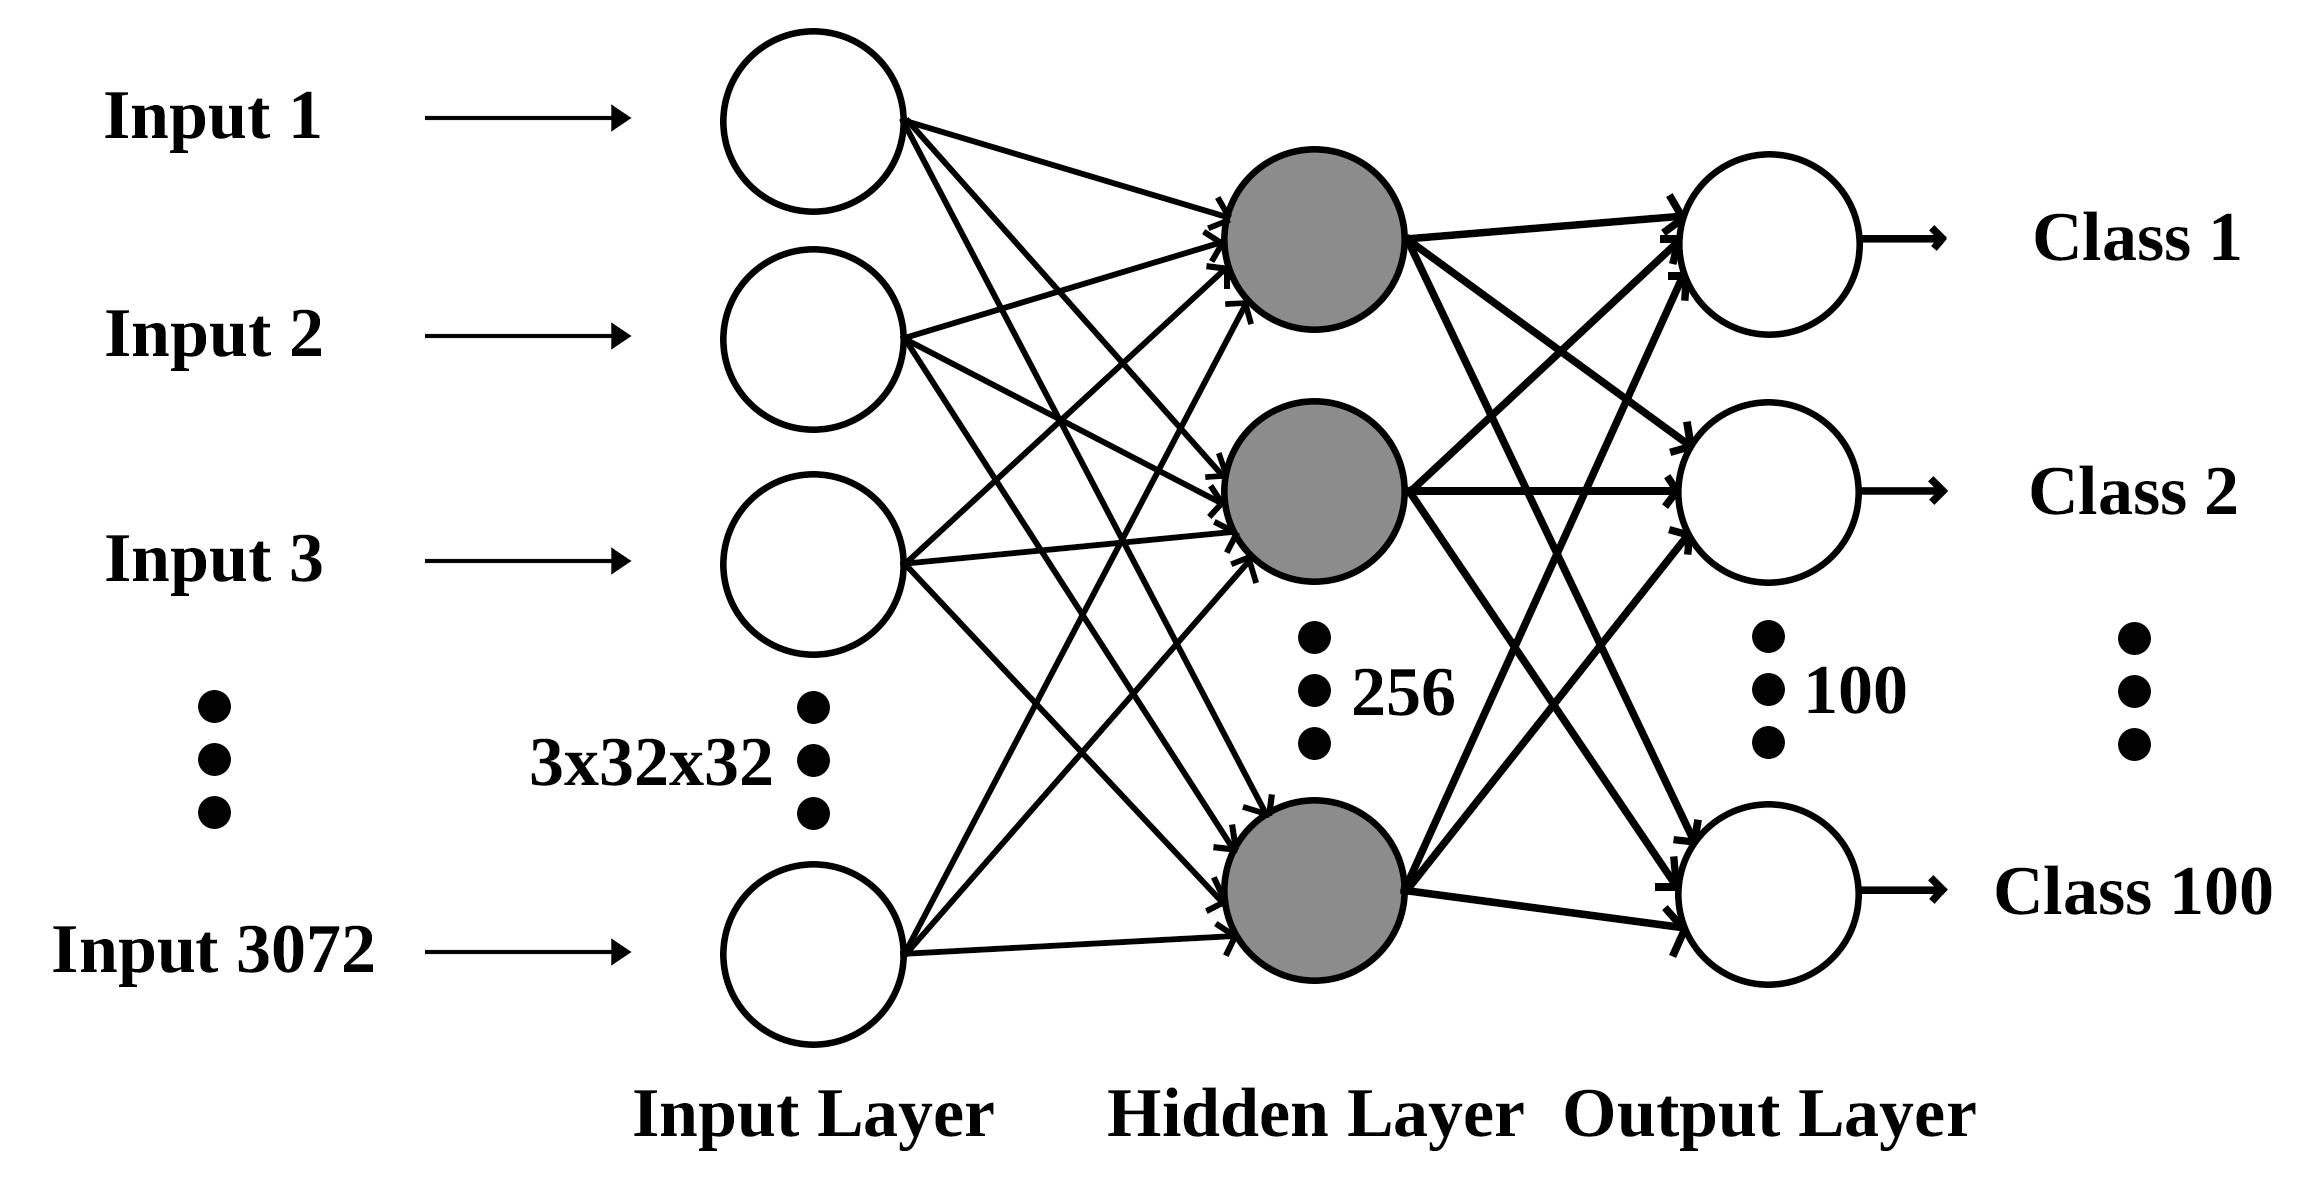

Στα MLPs, τα δεδομένα εισόδου τροφοδοτούνται σε ένα στρώμα εισόδου (input layer) που έχει διάσταση ίση με τη διάσταση του χώρου εισόδου. Στην περίπτωσή μου, αφού τροφοδοτήσω δείγματα εισόδου με 3072 χαρακτηριστικά ανά δείγμα, θα έχω 3072 νευρώνες στο στρώμα εισόδου. Κάθε feature εδώ είναι και ένα pixel από τα *3 (channels) x 32 (height) x 32 (width)*. Αφού υποβληθούν σε επεξεργασία από το στρώμα εισόδου, τα αποτελέσματα περνούν στο επόμενο στρώμα, το οποίο ονομάζεται κρυφό στρώμα. Το τελικό στρώμα είναι η έξοδος. Η δομή των νευρώνων εξαρτάται από το πρόβλημα (δηλαδή έχω ένα νευρώνα στα προβλήματα παλινδρόμησης και δυαδικής ταξινόμησης, ενώ πολλαπλούς νευρώνες σε ένα πρόβλημα ταξινόμησης πολλαπλών κλάσεων).

Κάθε νευρώνας περνάει την είσοδο σε όλους τους νευρώνες του επόμενου (ή downstream) στρώματος. Αυτός είναι ο λόγος για τον οποίο τέτοια στρώματα ονομάζονται επίσης πυκνά συνδεδεμένα (Dense). Στο TensorFlow και στο Keras είναι διαθέσιμα ως `tensorflow.keras.layers.Dense`. Το PyTorch τα χρησιμοποιεί ως `torch.nn.Linear`.


* **Το πρώτο βήμα είναι να προσθέσω όλα τα dependencies.**

Χρειάζομαι το `torch`, για το PyTorch. Από αυτό εισάγω το `nn`, το οποίο μου επιτρέπει να ορίσω και να εκπαιδεύσω ένα νευρωνικό δίκτυο. Επιπλέον, θέλω και το `optim` που παρέχει αλγόριθμους βελτιστοποίησης για την ενημέρωση των παραμέτρων κατά την εκπαίδευση του δικτύου. Εισάγω επίσης το `DataLoader` για την τροφοδοσία δεδομένων στο MLP κατά τη διάρκεια της εκπαίδευσης και το `TensorDataset` που επεξεργάζεται δεδομένα για να δημιουργώ δικά μου datasets από tensors.

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

* **Ακολουθεί ο ορισμός της κλάσης BaseModel.**

Αυτό το Module υλοποιεί το νευρωνικό μου δίκτυο. Έχει δύο ορισμούς συναρτήσεων: `__init__`, δηλαδή τον constructor και `forward` που υλοποιεί το forward pass.

Στον κατασκευαστή, κάνω πρώτα την αρχικοποίηση του `superclass` και μετά ορίζω τα επίπεδα του νευρωνικού μου δικτύου. Στοιβάζω όλα τα επίπεδα (τρία πυκνά συνδεδεμένα στρώματα με `Linear` και `ReLU`), χρησιμοποιώντας το `nn.Sequential`.

In [13]:
class BaseModel(nn.Module):
  '''
    Multilayer Perceptron - BaseModel.
  '''
  def __init__(self, num_features, num_classes):

    super(BaseModel, self).__init__()

    self.layers = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

* **Ορισμός του seed της γεννήτριας.**

Αυτός εκτελείται κατά το χρόνο εκτέλεσης. Ορίζω το seed της γεννήτριας τυχαίων αριθμών. Έτσι διασφαλίζω ότι η ανάλυση μου θα είναι κάθε φορά η ίδια.

In [25]:
if __name__ == '__main__':

  torch.manual_seed(42)

* **Προετοιμασία του συνόλου δεδομένων CIFAR-100**

Εδώ, αρχικά, μετατρέπω το `x_train_pca` από πίνακα NumPy σε tensor και το κρατώ ως `x_train_tensor` για να το χρησιμοποιήσω στο PyTorch. Μετά μετατρέπω τις one-hot κωδικοποιημένες ετικέτες `y_train_encoded` σε τένσορα. Με τη συνάρτηση `np.argmax` βρίσκω τον δείκτη της μέγιστης τιμής κατά μήκος του άξονα  (δηλαδή την τιμή 1).  Εν τέλει μετατρέπεται σε PyTorch tensor ως `y_train_tensor`.

Έπειτα, συνδυάζω τα χαρακτηριστικά εισόδου και τις ετικέτες για να δημιουργήσω το σύνολο μου θα φορτώσω στον `DataLoader`.

 Μετά αρχικοποιώ το  `DataLoader`, το οποίο παίρνει το σύνολο δεδομένων, το μέγεθος παρτίδας και μια παράμετρο για το αν θα γίνει `shuffle`. Στο PyTorch, οι `data loaders` χρησιμοποιούνται για την ομοιόμορφη τροφοδοσία δεδομένων στο μοντέλο.

In [26]:
x_train_tensor = torch.from_numpy(x_train_pca)
y_train_indices = np.argmax(y_train_encoded, axis=1)
y_train_tensor = torch.from_numpy(y_train_indices.astype(np.long))

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

train_loader = DataLoader(train_dataset, batch_size=250, shuffle=True)

<ipython-input-26-eb910ad282bb>:3: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train_tensor = torch.from_numpy(y_train_indices.astype(np.long))


Τώρα, αρχικοποιώ και το BaseModel. Καθορίζω επίσης τη συνάρτηση απώλειας (categorical crossentropy loss) και τον βελτιστοποιητή Adam. Ο βελτιστοποιητής λειτουργεί στις παραμέτρους του MLP και χρησιμοποιεί ρυθμό εκμάθησης 0.0001.

In [16]:
num_features = 32 * 32 * 3
num_features = 87
num_classes = 100

BaseModel = BaseModel(num_features, num_classes)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(BaseModel.parameters(), lr=1e-4)

* **Καθορισμός του training loop**

Το βασικό μέρος του κώδικα είναι ο βρόχος εκπαίδευσης. Σε αυτόν τον βρόχο, εκτελούνται οι εποχές, δηλαδή οι επαναλήψεις εκπαίδευσης. Για κάθε εποχή, επαναλαμβάνω σε όλο το σύνολο δεδομένων εκπαίδευσης το forward και το backward pass και έτσι βελτιστοποιώ το μοντέλο.

Εδώ, χρησιμοποιώ 10 εποχές, όπως ορίζονται από το εύρος `(0, 10)`. Ορίζω την αρχική τιμή απώλειας (`current_loss`) σε 0,0. Ανά εποχή, επαναλαμβάνω το σύνολο δεδομένων εκπαίδευσης και πιο συγκεκριμένα, τις μίνι παρτίδες σε αυτό το σύνολο, όπως καθορίζεται από το `batch_size`. Εδώ, κάνουμε τα εξής:

Χωρίζω τα δεδομένα σε `inputs` και `targets` (τιμές x και y). Μηδενίζω τα gradients στο βελτιστοποιητή (`zero_grad()`), για να διασφαλίσω ότι θα ξεκινήσει από την αρχή για αυτήν τη μίνι παρτίδα. Μετά εκτελώ το forward pass (`outputs = mlp(inputs)`), το οποίο στην πραγματικότητα τροφοδοτεί τις εισόδους στο μοντέλο. Στη συνέχεια, υπολογίζω την τιμή απώλειας με βάση τα αποτελέσματα του μοντέλου και την πραγματικότητα που υπάρχει στα `targets`. Ακολουθεί το backward pass, όπου υπολογίζονται τα gradients και έτσι φτάνω  στην βελτιστοποίηση, όπου το μοντέλο προσαρμόζεται και ιδανικά βελτιώνεται. Τελικά, εκτυπώνω ορισμένα στατιστικά στοιχεία σε κάθε παρτίδα των 28.

In [27]:
import matplotlib.pyplot as plt

In [28]:
def train_model(model, train_loader, optimizer, loss_function, num_epochs=10, mini_batch_print_interval=25):
    losses = []  # To store the loss values during training

    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch + 1}')

        current_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, targets = data

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()

            if i % mini_batch_print_interval == mini_batch_print_interval - 1:
                print(f'Loss after mini-batch {i + 1}: {current_loss / mini_batch_print_interval:.3f}')
                losses.append(current_loss / mini_batch_print_interval)
                current_loss = 0.0

    print('Training process has finished.')

    # Plot the loss
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Mini-batch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Mini-batches')
    plt.legend()
    plt.show()

Starting epoch 1
Loss after mini-batch 25: 4.638
Loss after mini-batch 50: 4.581
Loss after mini-batch 75: 4.535
Loss after mini-batch 100: 4.498
Loss after mini-batch 125: 4.459
Loss after mini-batch 150: 4.436
Loss after mini-batch 175: 4.401
Loss after mini-batch 200: 4.371
Starting epoch 2
Loss after mini-batch 25: 4.334
Loss after mini-batch 50: 4.306
Loss after mini-batch 75: 4.289
Loss after mini-batch 100: 4.253
Loss after mini-batch 125: 4.230
Loss after mini-batch 150: 4.203
Loss after mini-batch 175: 4.190
Loss after mini-batch 200: 4.165
Starting epoch 3
Loss after mini-batch 25: 4.141
Loss after mini-batch 50: 4.111
Loss after mini-batch 75: 4.098
Loss after mini-batch 100: 4.085
Loss after mini-batch 125: 4.052
Loss after mini-batch 150: 4.035
Loss after mini-batch 175: 4.008
Loss after mini-batch 200: 4.001
Starting epoch 4
Loss after mini-batch 25: 3.969
Loss after mini-batch 50: 3.972
Loss after mini-batch 75: 3.943
Loss after mini-batch 100: 3.939
Loss after mini-batc

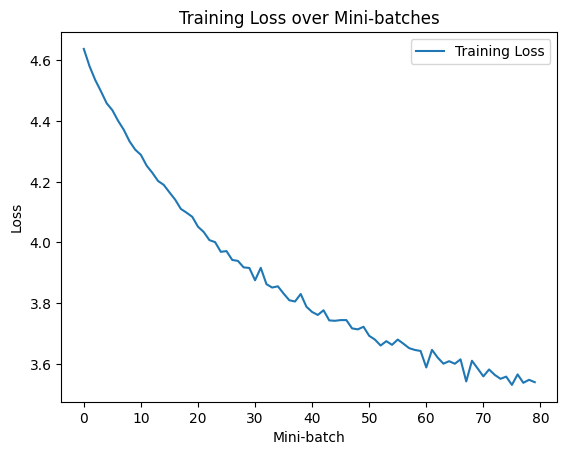

In [19]:
num_epochs = 10

train_model(BaseModel, train_loader, optimizer, loss_function, num_epochs)

# Μοντέλο 1.1

Τώρα σε 2 κρυφά στρώματα θα δοκιμάσω 512 νευρώνες για το πρώτο και 256 για το δεύτερο. Η εκπαίδευση γίνεται για 50 εποχές με Adam optimizer και ρυθμό εκμάθησης 0,001.

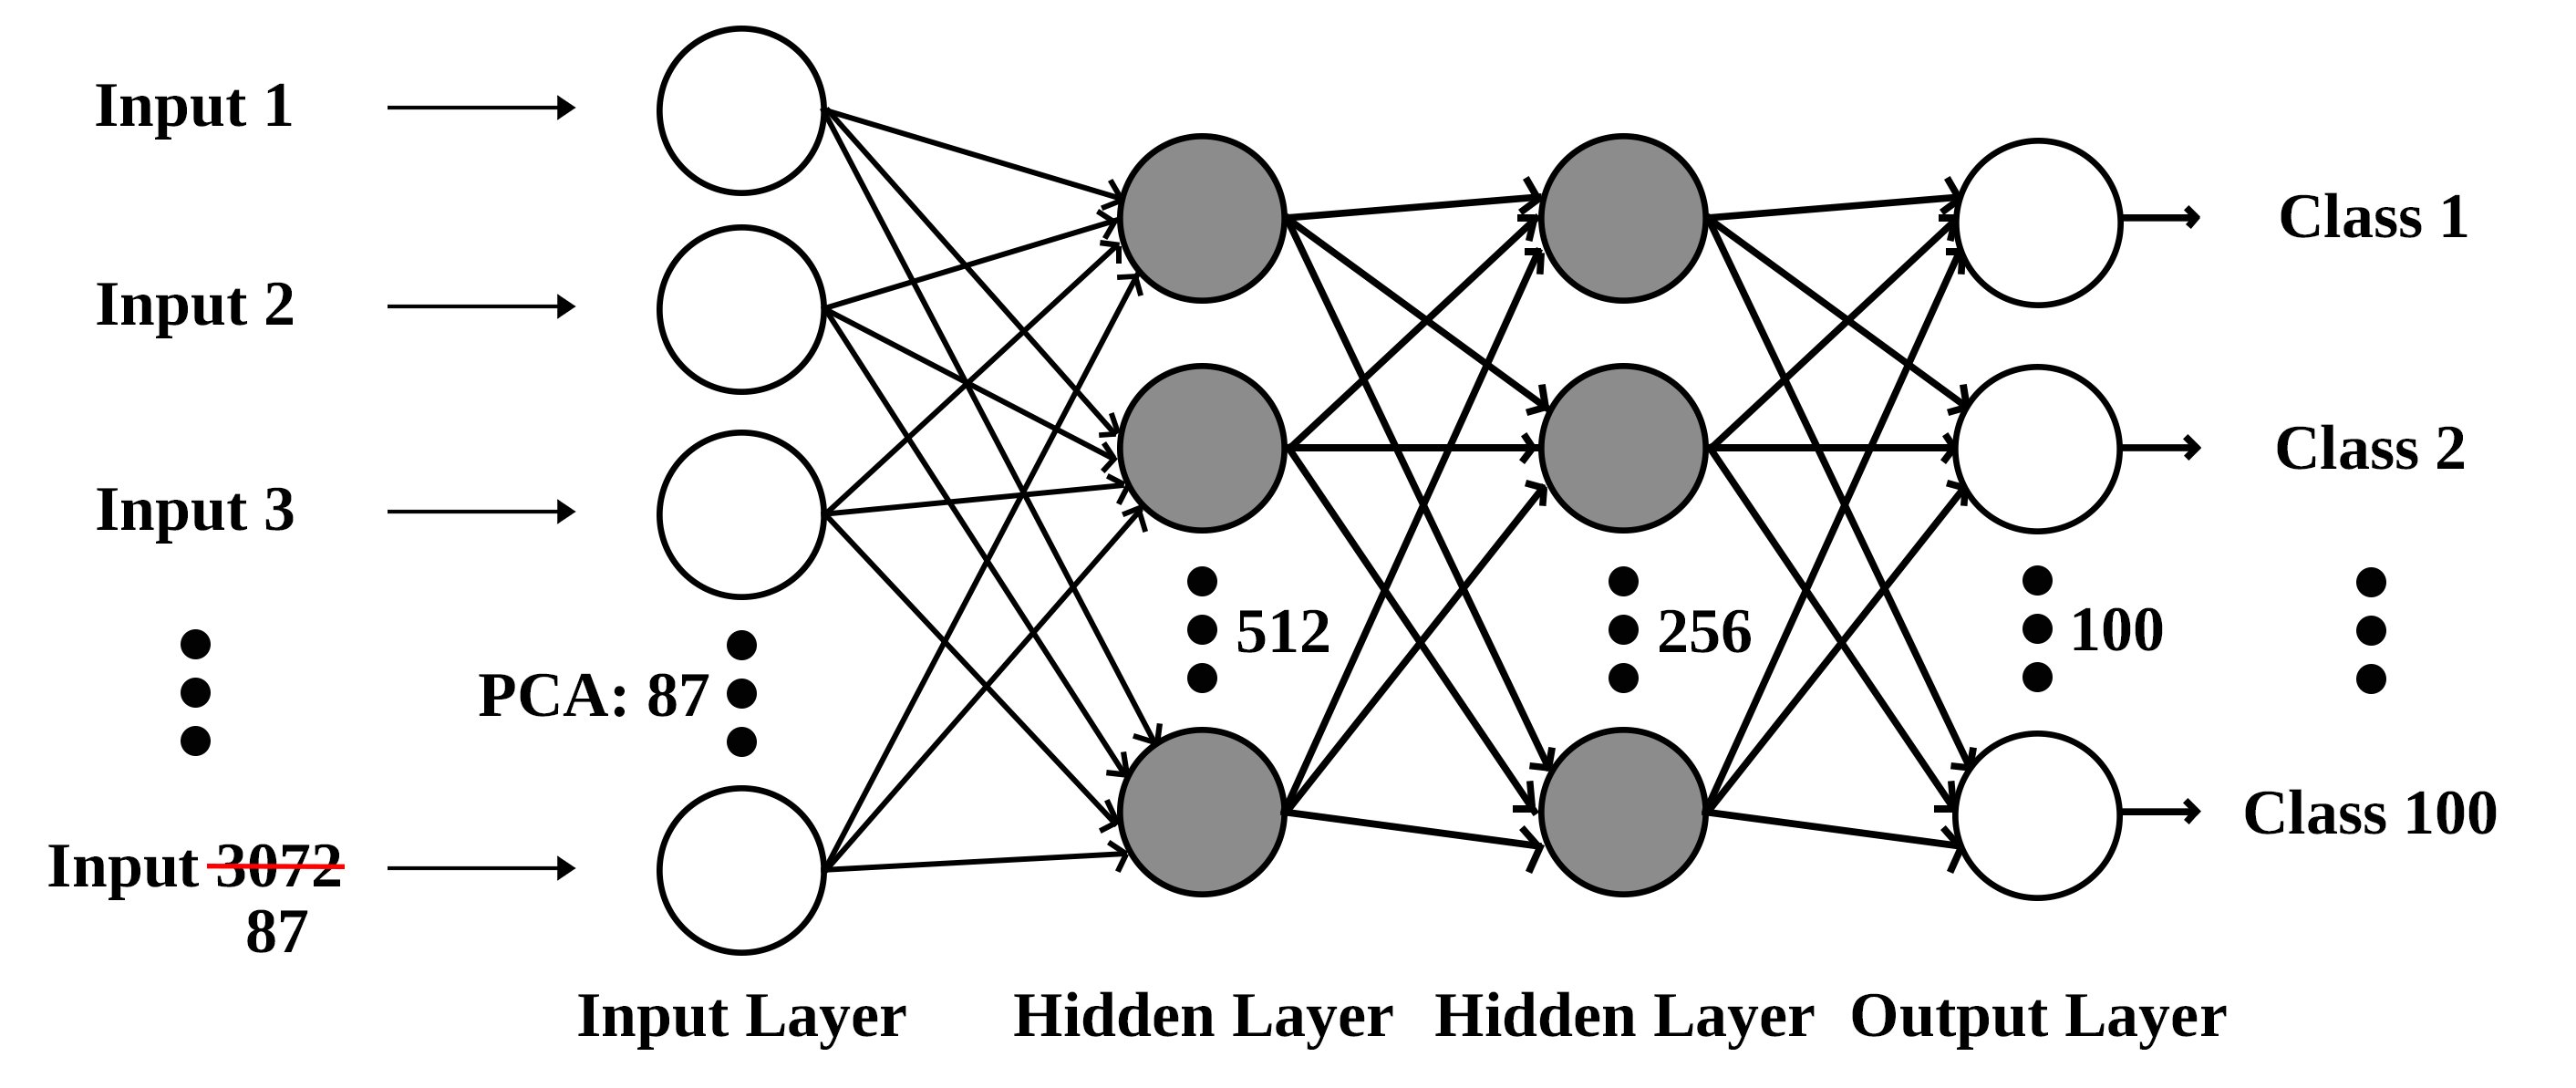

Starting epoch 1
Loss after mini-batch 25: 4.421
Loss after mini-batch 50: 4.060
Loss after mini-batch 75: 3.828
Loss after mini-batch 100: 3.738
Loss after mini-batch 125: 3.674
Loss after mini-batch 150: 3.623
Loss after mini-batch 175: 3.540
Loss after mini-batch 200: 3.499
Starting epoch 2
Loss after mini-batch 25: 3.358
Loss after mini-batch 50: 3.389
Loss after mini-batch 75: 3.367
Loss after mini-batch 100: 3.321
Loss after mini-batch 125: 3.328
Loss after mini-batch 150: 3.296
Loss after mini-batch 175: 3.266
Loss after mini-batch 200: 3.225
Starting epoch 3
Loss after mini-batch 25: 3.129
Loss after mini-batch 50: 3.133
Loss after mini-batch 75: 3.116
Loss after mini-batch 100: 3.116
Loss after mini-batch 125: 3.091
Loss after mini-batch 150: 3.079
Loss after mini-batch 175: 3.073
Loss after mini-batch 200: 3.055
Starting epoch 4
Loss after mini-batch 25: 2.915
Loss after mini-batch 50: 2.919
Loss after mini-batch 75: 2.944
Loss after mini-batch 100: 2.923
Loss after mini-batc

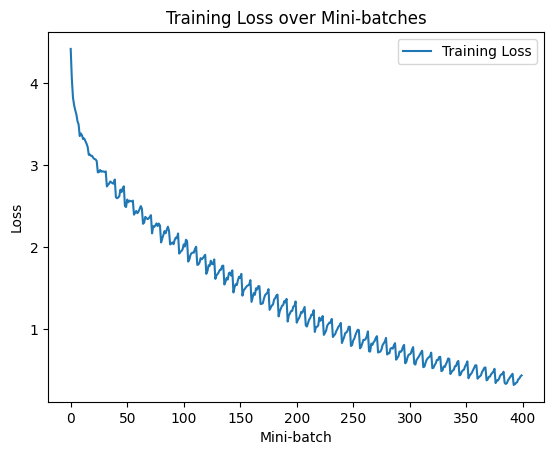

In [29]:
class Model_1_1(nn.Module):
  '''
    Multilayer Perceptron - Model_1_1.
  '''
  def __init__(self, num_features, num_classes):

    super(Model_1_1, self).__init__()

    self.layers = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

num_features = 87
num_classes = 100
Model_1_1 = Model_1_1(num_features, num_classes)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model_1_1.parameters(), lr=0.001)
num_epochs = 50

train_model(Model_1_1, train_loader, optimizer, loss_function, num_epochs)

# Μοντέλο 1.2

Τώρα, ας δούμε τι συμβαίνει χρησιμοποιώντας το ίδιο ακριβώς μοντέλο, αλλά εκπαιδεύοντάς το χρησιμοποιώντας μεγαλύτερο ρυθμό εκμάθησης 0,01.

Starting epoch 1
Loss after mini-batch 25: 4.186
Loss after mini-batch 50: 3.859
Loss after mini-batch 75: 3.784
Loss after mini-batch 100: 3.688
Loss after mini-batch 125: 3.659
Loss after mini-batch 150: 3.609
Loss after mini-batch 175: 3.601
Loss after mini-batch 200: 3.593
Starting epoch 2
Loss after mini-batch 25: 3.372
Loss after mini-batch 50: 3.406
Loss after mini-batch 75: 3.437
Loss after mini-batch 100: 3.432
Loss after mini-batch 125: 3.452
Loss after mini-batch 150: 3.411
Loss after mini-batch 175: 3.433
Loss after mini-batch 200: 3.431
Starting epoch 3
Loss after mini-batch 25: 3.210
Loss after mini-batch 50: 3.181
Loss after mini-batch 75: 3.235
Loss after mini-batch 100: 3.278
Loss after mini-batch 125: 3.300
Loss after mini-batch 150: 3.350
Loss after mini-batch 175: 3.270
Loss after mini-batch 200: 3.335
Starting epoch 4
Loss after mini-batch 25: 3.008
Loss after mini-batch 50: 3.089
Loss after mini-batch 75: 3.131
Loss after mini-batch 100: 3.166
Loss after mini-batc

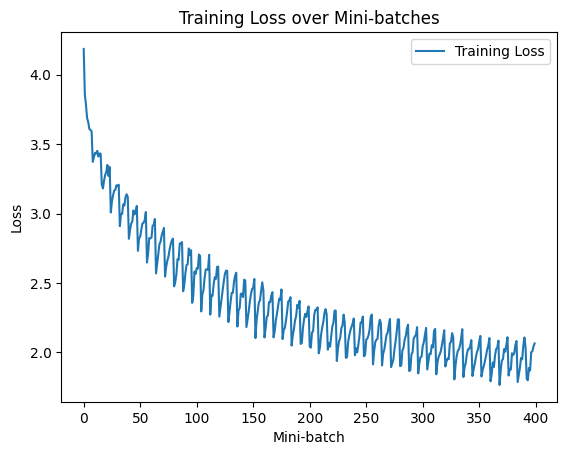

In [30]:
class Model_1_2(nn.Module):
  '''
    Multilayer Perceptron - Model_1_2.
  '''
  def __init__(self, num_features, num_classes):

    super(Model_1_2, self).__init__()

    self.layers = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

num_features = 87
num_classes = 100
Model_1_2 = Model_1_2(num_features, num_classes)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model_1_2.parameters(), lr=0.01)
num_epochs = 50

train_model(Model_1_2, train_loader, optimizer, loss_function, num_epochs)

Πρώτα απ 'όλα παρατηρώ ότι η απόδοση του μοντέλου είναι χειρότερη από το προηγούμενο που σημαίνει ότι ένα μικρότερο ποσοστό εκμάθησης είναι πιο κατάλληλο.

Επιπλέον, είναι σαφές ότι λόγω του υψηλότερου ρυθμού μάθησης ο αλγόριθμος ταλαντώνεται περισσότερο, καθιστώντας τη σύγκλιση πιο δύσκολη και προκαλώντας τις αιχμές που βλέπουμε στην καμπύλη μάθησης.